In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!python -m pip install roboflow
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling chardet-5.2.0:
      Successfully uninstalled chardet-5.2.0
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-gc5gellj
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-gc5gellj
  Resolved https://github.com/facebookresearch/detectron2.git to commit 2a420edb307c9bdf640f036d3b196bed474b8593
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [ ]:
from os import sys
%cd '/content/drive/MyDrive/Lower_Teeth_Images'

ROOT_DIR = "/content/drive/MyDrive/Lower_Teeth_Images"

# Import Mask RCNN
sys.path.append(ROOT_DIR)

import logging
import torch
from collections import OrderedDict
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.utils.visualizer import ColorMode
from detectron2.solver import build_lr_scheduler, build_optimizer
from detectron2.checkpoint import DetectionCheckpointer, PeriodicCheckpointer
from detectron2.utils.events import EventStorage
from detectron2.modeling import build_model
import detectron2.utils.comm as comm
from detectron2.engine import default_argument_parser, default_setup, default_writers, launch
from detectron2.data import (
    MetadataCatalog,
    build_detection_test_loader,
    build_detection_train_loader,
)
from detectron2.evaluation import (
    CityscapesInstanceEvaluator,
    CityscapesSemSegEvaluator,
    COCOEvaluator,
    COCOPanopticEvaluator,
    DatasetEvaluators,
    LVISEvaluator,
    PascalVOCDetectionEvaluator,
    SemSegEvaluator,
    inference_on_dataset,
    print_csv_format,
)

from roboflow import Roboflow

from matplotlib import pyplot as plt
from PIL import Image

/content/drive/MyDrive/Lower_Teeth_Images


In [ ]:

from roboflow import Roboflow
rf = Roboflow(api_key="MjPweo5at2ycYYkUr2RD")
project = rf.workspace("dentalverse").project("tooth_numbering_segmentation")
version = project.version(3)
dataset = version.download("coco-segmentation")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Tooth_numbering_segmentation-3 in coco-segmentation:: 100%|██████████| 1346/1346 [00:15<00:00, 87.85it/s]


In [ ]:
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
import os
import json

def convert_to_detectron2_format(image_dir, annotations_file):
    with open(annotations_file, 'r') as f:
        coco_data = json.load(f)

    images = coco_data['images']
    annotations = coco_data['annotations']
    categories = coco_data['categories']

    # Create a mapping from your custom class IDs to consecutive integers starting from 0
    category_mapping = {cat['id']: i for i, cat in enumerate(categories)}
    category_names = [cat['name'] for cat in categories]

    dataset_dicts = []

    for image in images:
        record = {}
        record["file_name"] = os.path.join(image_dir, image["file_name"])
        record["image_id"] = image["id"]
        record["height"] = image["height"]
        record["width"] = image["width"]

        objs = []
        for annotation in annotations:
            if annotation["image_id"] == image["id"]:
                # Map the category ID
                category_id = category_mapping[annotation["category_id"]]
                obj = {
                    "bbox": annotation["bbox"],
                    "bbox_mode": BoxMode.XYWH_ABS,
                    "segmentation": annotation["segmentation"],
                    "category_id": category_id,
                }
                objs.append(obj)

        record["annotations"] = objs
        dataset_dicts.append(record)

    return dataset_dicts, category_names

def register_coco_instances(name, image_dir, annotations_file):
    dataset_dicts, category_names = convert_to_detectron2_format(image_dir, annotations_file)

    DatasetCatalog.register(name, lambda: dataset_dicts)
    MetadataCatalog.get(name).set(thing_classes=category_names)

    return category_names

# Register your dataset and get category names
train_category_names = register_coco_instances("teeth_dataset_train", "/content/drive/MyDrive/Lower_Teeth_Images/Tooth_numbering_segmentation-3/train", "/content/drive/MyDrive/Lower_Teeth_Images/Tooth_numbering_segmentation-3/train/_annotations.coco.json")
val_category_names = register_coco_instances("teeth_dataset_val", "/content/drive/MyDrive/Lower_Teeth_Images/Tooth_numbering_segmentation-3/valid", "/content/drive/MyDrive/Lower_Teeth_Images/Tooth_numbering_segmentation-3/valid/_annotations.coco.json")
test_category_names = register_coco_instances("teeth_dataset_test", "/content/drive/MyDrive/Lower_Teeth_Images/Tooth_numbering_segmentation-3/test", "/content/drive/MyDrive/Lower_Teeth_Images/Tooth_numbering_segmentation-3/test/_annotations.coco.json")


In [ ]:
register_coco_instances("teeth_dataset_train", {}, f"/content/drive/MyDrive/new_train/tooth-1/train/_annotations.coco.json", f"/content/drive/MyDrive/new_train/tooth-1/train/")
register_coco_instances("teeth_dataset_val", {}, f"/content/drive/MyDrive/new_train/tooth-1/valid/_annotations.coco.json", f"/content/drive/MyDrive/new_train/tooth-1/valid/")
register_coco_instances("teeth_dataset_test", {}, f"/content/drive/MyDrive/new_train/tooth-1/test/_annotations.coco.json", f"/content/drive/MyDrive/new_train/tooth-1/test/")

{'bbox': [148, 310, 64.199, 94.507], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'segmentation': [[161.281, 323.84, 159.573, 325.12, 158.434, 327.467, 156.014, 330.453, 154.306, 336.64, 153.31, 338.987, 151.744, 346.453, 150.747, 349.227, 149.609, 354.987, 148.754, 357.333, 147.9, 363.733, 147.758, 373.76, 148.327, 380.373, 150.178, 387.84, 155.587, 398.72, 161.281, 403.413, 163.416, 404.053, 166.833, 404.053, 173.95, 402.347, 178.221, 400.427, 181.352, 396.587, 183.772, 395.52, 186.477, 395.093, 188.185, 394.027, 190.178, 393.6, 193.879, 391.893, 196.441, 391.467, 198.577, 389.547, 201.281, 384.853, 202.42, 382.08, 204.27, 379.733, 208.968, 368.64, 211.53, 357.76, 211.957, 350.08, 211.388, 344.96, 208.541, 334.933, 203.701, 326.827, 198.719, 320.64, 195.587, 318.08, 193.879, 315.307, 189.609, 310.187, 185.623, 309.547, 180.356, 311.04, 175.801, 313.813, 172.527, 314.88, 170.819, 316.373, 164.982, 319.573, 162.562, 321.707, 161.281, 323.84]], 'category_id': 13}
13
{'bbox': [169, 392, 59.929, 9

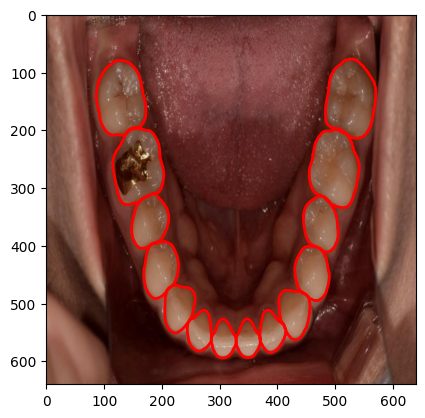

In [ ]:
dataset_train = DatasetCatalog.get("teeth_dataset_train")
fig, ax = plt.subplots()
dataset_dict = random.choice(dataset_train)
im = Image.open(dataset_dict['file_name'])
ax.imshow(im)
for ann in dataset_dict['annotations']:
    print(ann)
    for poly in ann['segmentation']:
        x = poly[0::2]
        y = poly[1::2]
        category = ann['category_id']
        print(category)
        ax.plot(x,y, category, linewidth=2, color='red')

In [ ]:

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("teeth_dataset_train",)#Train dataset registered in a previous cell
cfg.DATASETS.TEST = ("teeth_dataset_test",)#Test dataset registered in a previous cell
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 10000 #We found that with a patience of 500, training will early stop before 10,000 iterations
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 600
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 17 # 26 letters plus one super class
cfg.SOLVER.IMS_PER_BATCH=2
cfg.INPUT.MASK_FORMAT='bitmask'
cfg.MODEL.DEVICE = "gpu"
cfg.TEST.EVAL_PERIOD = 200 # Increase this number if you want to monitor validation performance during training

PATIENCE = 500 #Early stopping will occur after N iterations of no imporovement in total_loss

cfg.OUTPUT_DIR = "/content/drive/MyDrive/new_train/output"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [ ]:
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[07/17 19:12:41 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[07/17 19:12:42 d2.engine.train_loop]: Starting training from iteration 0


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[07/17 19:12:52 d2.utils.events]:  eta: 1:22:18  iter: 19  total_loss: 4.78  loss_cls: 2.771  loss_box_reg: 0.6159  loss_mask: 0.6928  loss_rpn_cls: 0.6265  loss_rpn_loc: 0.05708    time: 0.4926  last_time: 0.4697  data_time: 0.0255  last_data_time: 0.0259   lr: 4.9953e-06  max_mem: 3546M
[07/17 19:13:03 d2.utils.events]:  eta: 1:27:36  iter: 39  total_loss: 4.328  loss_cls: 2.614  loss_box_reg: 0.7561  loss_mask: 0.6918  loss_rpn_cls: 0.2593  loss_rpn_loc: 0.04763    time: 0.5241  last_time: 0.4596  data_time: 0.0180  last_data_time: 0.0115   lr: 9.9902e-06  max_mem: 3757M
[07/17 19:13:14 d2.utils.events]:  eta: 1:29:04  iter: 59  total_loss: 3.908  loss_cls: 2.277  loss_box_reg: 0.8475  loss_mask: 0.6897  loss_rpn_cls: 0.09041  loss_rpn_loc: 0.04204    time: 0.5363  last_time: 0.5429  data_time: 0.0174  last_data_time: 0.0118   lr: 1.4985e-05  max_mem: 3803M
[07/17 19:13:25 d2.utils.events]:  eta: 1:29:57  iter: 79  total_loss: 3.408  loss_cls: 1.775  loss_box_reg: 0.8571  loss_mask:

In [ ]:
##Without Patience Code Training



def get_evaluator(cfg, dataset_name, output_folder=None):
    """
    Create evaluator(s) for a given dataset.
    This uses the special metadata "evaluator_type" associated with each builtin dataset.
    For your own dataset, you can simply create an evaluator manually in your
    script and do not have to worry about the hacky if-else logic here.
    """
    if output_folder is None:
        output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
    evaluator_list = []
    evaluator_type = MetadataCatalog.get(dataset_name).evaluator_type
    if evaluator_type in ["sem_seg", "coco_panoptic_seg"]:
        evaluator_list.append(
            SemSegEvaluator(
                dataset_name,
                distributed=True,
                output_dir=output_folder,
            )
        )
    if evaluator_type in ["coco", "coco_panoptic_seg"]:
        evaluator_list.append(COCOEvaluator(dataset_name, output_dir=output_folder))
    if evaluator_type == "coco_panoptic_seg":
        evaluator_list.append(COCOPanopticEvaluator(dataset_name, output_folder))
    if evaluator_type == "cityscapes_instance":
        return CityscapesInstanceEvaluator(dataset_name)
    if evaluator_type == "cityscapes_sem_seg":
        return CityscapesSemSegEvaluator(dataset_name)
    if evaluator_type == "pascal_voc":
        return PascalVOCDetectionEvaluator(dataset_name)
    if evaluator_type == "lvis":
        return LVISEvaluator(dataset_name, cfg, True, output_folder)
    if len(evaluator_list) == 0:
        raise NotImplementedError(
            "no Evaluator for the dataset {} with the type {}".format(dataset_name, evaluator_type)
        )
    if len(evaluator_list) == 1:
        return evaluator_list[0]
    return DatasetEvaluators(evaluator_list)

def do_test(cfg, model):
    results = OrderedDict()
    for dataset_name in cfg.DATASETS.TEST:
        data_loader = build_detection_test_loader(cfg, dataset_name)
        evaluator = get_evaluator(
            cfg, dataset_name, os.path.join(cfg.OUTPUT_DIR, "inference", dataset_name)
        )
        results_i = inference_on_dataset(model, data_loader, evaluator)
        results[dataset_name] = results_i
        if comm.is_main_process():
            logger.info("Evaluation results for {} in csv format:".format(dataset_name))
            print_csv_format(results_i)
    if len(results) == 1:
        results = list(results.values())[0]
    return results


logger = logging.getLogger("detectron2")
resume = False
model = build_model(cfg)
optimizer = build_optimizer(cfg, model)
scheduler = build_lr_scheduler(cfg, optimizer)

BEST_LOSS = np.inf

checkpointer = DetectionCheckpointer(
    model, cfg.OUTPUT_DIR, optimizer=optimizer, scheduler=scheduler
)
start_iter = (
    checkpointer.resume_or_load(cfg.MODEL.WEIGHTS, resume=resume).get("iteration", -1) + 1
)
max_iter = cfg.SOLVER.MAX_ITER

periodic_checkpointer = PeriodicCheckpointer(
    checkpointer, cfg.SOLVER.CHECKPOINT_PERIOD, max_iter=max_iter
)

writers = default_writers(cfg.OUTPUT_DIR, max_iter) if comm.is_main_process() else []

# compared to "train_net.py", we do not support accurate timing and
# precise BN here, because they are not trivial to implement in a small training loop
data_loader = build_detection_train_loader(cfg)
logger.info("Starting training from iteration {}".format(start_iter))

with EventStorage(start_iter) as storage:
    for data, iteration in zip(data_loader, range(start_iter, max_iter)):
        storage.iter = iteration

        loss_dict = model(data)
        losses = sum(loss_dict.values())
        assert torch.isfinite(losses).all(), loss_dict

        loss_dict_reduced = {k: v.item() for k, v in comm.reduce_dict(loss_dict).items()}
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())
        if comm.is_main_process():
            storage.put_scalars(total_loss=losses_reduced, **loss_dict_reduced)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        storage.put_scalar("lr", optimizer.param_groups[0]["lr"], smoothing_hint=False)
        scheduler.step()

        if (
            cfg.TEST.EVAL_PERIOD > 0
            and (iteration + 1) % cfg.TEST.EVAL_PERIOD == 0
            and iteration != max_iter - 1
        ):
            do_test(cfg, model)
            # Compared to "train_net.py", the test results are not dumped to EventStorage
            comm.synchronize()

        if iteration - start_iter > 5 and (
            (iteration + 1) % 20 == 0 or iteration == max_iter - 1
        ):
            for writer in writers:
                writer.write()
        periodic_checkpointer.step(iteration)

do_test(cfg, model)


[07/17 19:10:00 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


model_final_f10217.pkl: 178MB [00:00, 226MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[07/17 19:10:02 d2.data.build]: Removed 0 images with no usable annotations. 1260 images left.
[07/17 19:10:02 d2.data.build]: Distribution of instances among all 17 categories:
|  category  | #instances   | category   | #instances   | category   | #instances   |
|:----------:|:-------------|:-----------|:-------------|:-----------|:-------------|
|   teeth    | 0            | 31         | 1260         | 32         | 1260         |
|     33     | 1257         | 34         | 1251         | 35         | 1179         |
|     36     | 1254         | 37         | 1221         | 38         | 186          |
|     41     | 1257         | 42         | 1257         | 43         | 1248         |
|     44     | 1242         | 45         | 1176         | 46         | 1242         |
|     47     | 1197         | 48         | 186          |            |              |
|   total    | 17673        |            |              |            |              |
[07/17 19:10:02 d2.data.dataset_mapper]: [Datase

torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)


[07/17 19:10:16 d2.utils.events]:  iter: 19  total_loss: 4.8  loss_cls: 2.908  loss_box_reg: 0.6567  loss_mask: 0.6933  loss_rpn_cls: 0.5392  loss_rpn_loc: 0.054     lr: 4.9953e-06  max_mem: 3121M
[07/17 19:10:31 d2.utils.events]:  eta: 1:59:07  iter: 39  total_loss: 4.537  loss_cls: 2.743  loss_box_reg: 0.7532  loss_mask: 0.6918  loss_rpn_cls: 0.2959  loss_rpn_loc: 0.05528     lr: 9.9902e-06  max_mem: 3276M
[07/17 19:10:41 d2.utils.events]:  eta: 1:25:35  iter: 59  total_loss: 4.056  loss_cls: 2.462  loss_box_reg: 0.8159  loss_mask: 0.689  loss_rpn_cls: 0.06855  loss_rpn_loc: 0.04056     lr: 1.4985e-05  max_mem: 3276M
[07/17 19:10:52 d2.utils.events]:  eta: 1:33:11  iter: 79  total_loss: 3.65  loss_cls: 2.026  loss_box_reg: 0.8546  loss_mask: 0.6853  loss_rpn_cls: 0.04619  loss_rpn_loc: 0.04405     lr: 1.998e-05  max_mem: 3291M
[07/17 19:11:03 d2.utils.events]:  eta: 1:25:43  iter: 99  total_loss: 3.104  loss_cls: 1.482  loss_box_reg: 0.864  loss_mask: 0.6801  loss_rpn_cls: 0.04632  l

AttributeError: Attribute 'evaluator_type' does not exist in the metadata of dataset 'teeth_dataset_test'. Available keys are dict_keys(['name', 'thing_classes']).

In [ ]:
def get_evaluator(cfg, dataset_name, output_folder=None):
    """
    Create evaluator(s) for a given dataset.
    This uses the special metadata "evaluator_type" associated with each builtin dataset.
    For your own dataset, you can simply create an evaluator manually in your
    script and do not have to worry about the hacky if-else logic here.
    """
    if output_folder is None:
        output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
    evaluator_list = []
    evaluator_type = MetadataCatalog.get(dataset_name).evaluator_type
    if evaluator_type in ["sem_seg", "coco_panoptic_seg"]:
        evaluator_list.append(
            SemSegEvaluator(
                dataset_name,
                distributed=True,
                output_dir=output_folder,
            )
        )
    if evaluator_type in ["coco", "coco_panoptic_seg"]:
        evaluator_list.append(COCOEvaluator(dataset_name, output_dir=output_folder))
    if evaluator_type == "coco_panoptic_seg":
        evaluator_list.append(COCOPanopticEvaluator(dataset_name, output_folder))
    if evaluator_type == "cityscapes_instance":
        return CityscapesInstanceEvaluator(dataset_name)
    if evaluator_type == "cityscapes_sem_seg":
        return CityscapesSemSegEvaluator(dataset_name)
    if evaluator_type == "pascal_voc":
        return PascalVOCDetectionEvaluator(dataset_name)
    if evaluator_type == "lvis":
        return LVISEvaluator(dataset_name, cfg, True, output_folder)
    if len(evaluator_list) == 0:
        raise NotImplementedError(
            "no Evaluator for the dataset {} with the type {}".format(dataset_name, evaluator_type)
        )
    if len(evaluator_list) == 1:
        return evaluator_list[0]
    return DatasetEvaluators(evaluator_list)

def do_test(cfg, model):
    results = OrderedDict()
    for dataset_name in cfg.DATASETS.TEST:
        data_loader = build_detection_test_loader(cfg, dataset_name)
        evaluator = get_evaluator(
            cfg, dataset_name, os.path.join(cfg.OUTPUT_DIR, "inference", dataset_name)
        )
        results_i = inference_on_dataset(model, data_loader, evaluator)
        results[dataset_name] = results_i
        if comm.is_main_process():
            logger.info("Evaluation results for {} in csv format:".format(dataset_name))
            print_csv_format(results_i)
    if len(results) == 1:
        results = list(results.values())[0]
    return results


logger = logging.getLogger("detectron2")
resume=False
model = build_model(cfg)
optimizer = build_optimizer(cfg, model)
scheduler = build_lr_scheduler(cfg, optimizer)

BEST_LOSS = np.inf

checkpointer = DetectionCheckpointer(
    model, cfg.OUTPUT_DIR, optimizer=optimizer, scheduler=scheduler
)
start_iter = (
    checkpointer.resume_or_load(cfg.MODEL.WEIGHTS, resume=resume).get("iteration", -1) + 1
)
prev_iter = start_iter
max_iter = cfg.SOLVER.MAX_ITER

periodic_checkpointer = PeriodicCheckpointer(
    checkpointer, cfg.SOLVER.CHECKPOINT_PERIOD, max_iter=max_iter
)

writers = default_writers(cfg.OUTPUT_DIR, max_iter) if comm.is_main_process() else []

# compared to "train_net.py", we do not support accurate timing and
# precise BN here, because they are not trivial to implement in a small training loop
data_loader = build_detection_train_loader(cfg)
logger.info("Starting training from iteration {}".format(start_iter))
patience_counter = 0
with EventStorage(start_iter) as storage:
    for data, iteration in zip(data_loader, range(start_iter, max_iter)):
        storage.iter = iteration

        loss_dict = model(data)
        losses = sum(loss_dict.values())
        assert torch.isfinite(losses).all(), loss_dict

        loss_dict_reduced = {k: v.item() for k, v in comm.reduce_dict(loss_dict).items()}
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())
        if comm.is_main_process():
            storage.put_scalars(total_loss=losses_reduced, **loss_dict_reduced)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        storage.put_scalar("lr", optimizer.param_groups[0]["lr"], smoothing_hint=False)
        scheduler.step()

        if (
            cfg.TEST.EVAL_PERIOD > 0
            and (iteration + 1) % cfg.TEST.EVAL_PERIOD == 0
            and iteration != max_iter - 1
        ):
            do_test(cfg, model)
            # Compared to "train_net.py", the test results are not dumped to EventStorage
            comm.synchronize()

        if iteration - start_iter > 5 and (
            (iteration + 1) % 20 == 0 or iteration == max_iter - 1
        ):
            for writer in writers:
                writer.write()
        periodic_checkpointer.step(iteration)

        if iteration > prev_iter:
            prev_iter = iteration
            if losses_reduced < BEST_LOSS:
                BEST_LOSS = losses_reduced
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter % 100 == 0:
                    print(f"Loss has not improved for {patience_counter} iterations")
                if patience_counter >= PATIENCE:
                    print(f"EARLY STOPPING")
                    break

do_test(cfg, model)

[07/14 09:28:50 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


WARNING [07/14 09:28:50 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/14 09:28:50 d2.data.datasets.coco]: Loaded 399 images in COCO format from /content/drive/MyDrive/new_train/tooth-1/train/_annotations.coco.json
[07/14 09:28:50 d2.data.build]: Removed 0 images with no usable annotations. 399 images left.
[07/14 09:28:50 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[07/14 09:28:50 d2.data.build]: Using training sampler TrainingSampler
[07/14 09:28:50 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[07/14 09:28:50 d2.data.common]: Serializing 399 elements to byte tensors and concatenating them all ...
[07/14 09:28:50 d2.data.common]: Serialized dataset takes 4.25 MiB
[07/14 09:28:50 d2.data.build]: Making batched 

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[07/14 09:28:56 d2.utils.events]:  iter: 19  total_loss: 4.705  loss_cls: 2.875  loss_box_reg: 0.6927  loss_mask: 0.6916  loss_rpn_cls: 0.4029  loss_rpn_loc: 0.05783     lr: 4.9953e-06  max_mem: 2274M
[07/14 09:29:01 d2.utils.events]:  eta: 0:43:33  iter: 39  total_loss: 4.327  loss_cls: 2.704  loss_box_reg: 0.8105  loss_mask: 0.6902  loss_rpn_cls: 0.08663  loss_rpn_loc: 0.04229     lr: 9.9902e-06  max_mem: 2274M
[07/14 09:29:06 d2.utils.events]:  eta: 0:43:40  iter: 59  total_loss: 3.989  loss_cls: 2.368  loss_box_reg: 0.8215  loss_mask: 0.6874  loss_rpn_cls: 0.05221  loss_rpn_loc: 0.04024     lr: 1.4985e-05  max_mem: 2274M
[07/14 09:29:11 d2.utils.events]:  eta: 0:43:05  iter: 79  total_loss: 3.467  loss_cls: 1.867  loss_box_reg: 0.8257  loss_mask: 0.6827  loss_rpn_cls: 0.05231  loss_rpn_loc: 0.0363     lr: 1.998e-05  max_mem: 2274M
[07/14 09:29:17 d2.utils.events]:  eta: 0:43:39  iter: 99  total_loss: 2.927  loss_cls: 1.337  loss_box_reg: 0.842  loss_mask: 0.6767  loss_rpn_cls: 0.04

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[07/14 09:54:14 d2.evaluation.evaluator]: Inference done 11/40. Dataloading: 0.0012 s/iter. Inference: 0.0458 s/iter. Eval: 0.0301 s/iter. Total: 0.0771 s/iter. ETA=0:00:02
[07/14 09:54:17 d2.evaluation.evaluator]: Total inference time: 0:00:02.770976 (0.079171 s / iter per device, on 1 devices)
[07/14 09:54:17 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:01 (0.043777 s / iter per device, on 1 devices)
[07/14 09:54:17 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[07/14 09:54:17 d2.evaluation.coco_evaluation]: Saving results to /content/drive/MyDrive/new_train/output/inference/teeth_dataset_test/coco_instances_results.json
[07/14 09:54:17 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[07/14 09:54:17 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[07/14 09:54:17 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluat

OrderedDict([('bbox',
              {'AP': 50.72924474007196,
               'AP50': 53.87343309184469,
               'AP75': 53.87343309184469,
               'APs': nan,
               'APm': 50.58519334963248,
               'APl': 61.3217917644861,
               'AP-teeth': nan,
               'AP-11': 56.80465994629107,
               'AP-12': 58.83822878818993,
               'AP-13': 53.83100375727049,
               'AP-14': 65.30350288232111,
               'AP-15': 53.418146675212206,
               'AP-16': 56.57170647627758,
               'AP-17': 49.66953177602888,
               'AP-18': 48.003300330033,
               'AP-21': 57.81211516662833,
               'AP-22': 53.99069373011578,
               'AP-23': 47.1225025694377,
               'AP-24': 51.62201033177818,
               'AP-25': 49.78587495190585,
               'AP-26': 45.56492460548654,
               'AP-27': 51.61024190698002,
               'AP-28': 11.71947194719472}),
             ('segm',
    

# Test model and show example output

In [ ]:
## Testing with Seen Dataset ##
cfg.MODEL.WEIGHTS = '/content/drive/MyDrive/new_train/output/model_0004999.pth' # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 17
predictor = DefaultPredictor(cfg)

dataset_dicts = DatasetCatalog.get("teeth_dataset_test")
class_mapping = {i: 30 + i for i in range(1, 9)}  # Maps 1-8 to 11-18
class_mapping.update({i: 40 + (i - 8) for i in range(9, 17)})
def convert_pred_classes(pred_classes):
    return [class_mapping[int(cls)] for cls in pred_classes]

for d in random.sample(dataset_dicts, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)

    # Convert predicted classes
    pred_classes = outputs["instances"].pred_classes
    pred_classes_converted = torch.tensor(convert_pred_classes(pred_classes))

    print("Original pred_classes:", pred_classes)
    print("Converted pred_classes:", pred_classes_converted)

    # Update the outputs to include the converted classes
    outputs["instances"].pred_classes = pred_classes_converted

    v = Visualizer(im[:, :, ::-1], scale=1, instance_mode=ColorMode.IMAGE_BW)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    im = Image.fromarray(out.get_image()[:, :, ::-1])
    im.show()

[07/18 08:21:26 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/new_train/output/model_0004999.pth ...
Original pred_classes: tensor([15,  5, 10,  3,  5,  1,  6,  6, 12,  4,  1, 11,  4, 10, 15,  2])
Converted pred_classes: tensor([47, 35, 42, 33, 35, 31, 36, 36, 44, 34, 31, 43, 34, 42, 47, 32])
Original pred_classes: tensor([ 3, 12,  3,  9, 10,  6,  5,  6,  5, 11, 12,  9, 15,  7, 13, 10,  2,  1,
         7])
Converted pred_classes: tensor([33, 44, 33, 41, 42, 36, 35, 36, 35, 43, 44, 41, 47, 37, 45, 42, 32, 31,
        37])
Original pred_classes: tensor([ 5, 10,  5,  7,  3,  9,  2,  4, 14, 11,  3,  9, 15, 12,  7,  6,  4,  6,
        14, 10,  2, 12])
Converted pred_classes: tensor([35, 42, 35, 37, 33, 41, 32, 34, 46, 43, 33, 41, 47, 44, 37, 36, 34, 36,
        46, 42, 32, 44])


# Download trained model for future inference

In [ ]:
from google.colab import files
files.download(os.path.join(cfg.OUTPUT_DIR, "model_final.pth"))

Mounted at /content/drive
